In [ ]:
import os
import warnings

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from kaggle_datasets import KaggleDatasets
import transformers
import traitlets
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from tokenizers import BertWordPieceTokenizer
from sklearn.metrics import roc_auc_score

warnings.simplefilter("ignore")

## Helper Functions

In [ ]:
class TextTransformation:
    def __call__(self, text: str, lang: str = None) -> tuple:
        raise NotImplementedError('Abstarct')   
        
class LowerCaseTransformation(TextTransformation):
    def __call__(self, text: str, lang: str = None) -> tuple:
        return text.lower(), lang
    
    
class URLTransformation(TextTransformation):
    def __call__(self, text: str, lang: str = None) -> tuple:
        for url in self.find_urls(text):
            if url in text:
                text.replace(url, ' external link ')
        return text.lower(), lang
    
    @staticmethod
    def find_urls(string): 
        # https://www.geeksforgeeks.org/python-check-url-string/
        urls = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', string) 
        return urls 
    
class PunctuationTransformation(TextTransformation):
    def __call__(self, text: str, lang: str = None) -> tuple:
        for p in '?!.,"#$%\'()*+-/:;<=>@[\\]^_`{|}~' + '“”’' +"/-'" + "&" + "¡¿":
            if '’' in text:
                text = text.replace('’', f' \' ')
                
            if '’' in text:
                text = text.replace('’', f' \' ')
              
            if '—' in text:
                text = text.replace('—', f' - ')
                
            if '−' in text:
                text = text.replace('−', f' - ')   
                
            if '–' in text:
                text = text.replace('–', f' - ')   
              
            if '“' in text:
                text = text.replace('“', f' " ')   
                
            if '«' in text:
                text = text.replace('«', f' " ')   
                
            if '»' in text:
                text = text.replace('»', f' " ')   
            
            if '”' in text:
                text = text.replace('”', f' " ') 
                
            if '`' in text:
                text = text.replace('`', f' \' ')              

            text = text.replace(p, f' {p} ')
                
        return text.strip(), lang
    
    
class NumericTransformation(TextTransformation):
    def __call__(self, text: str, lang: str = None) -> tuple:
        for i in range(10):
            text = text.replace(str(i), f' {str(i)} ')
        return text, lang
    
class WikiTransformation(TextTransformation):
    def __call__(self, text: str, lang: str = None) -> tuple:
        text = text.replace('wikiproject', ' wiki project ')
        for i in [' vikipedi ', ' wiki ', ' википедии ', " вики ", ' википедия ', ' viki ', ' wikipedien ', ' википедию ']:
            text = text.replace(i, ' wikipedia ')
        return text, lang
    
    
class MessageTransformation(TextTransformation):
    def __call__(self, text: str, lang: str = None) -> tuple:
        text = text.replace('wikiproject', ' wiki project ')
        for i in [' msg ', ' msj ', ' mesaj ']:
            text = text.replace(i, ' message ')
        return text, lang
    
    
class PixelTransformation(TextTransformation):
    def __call__(self, text: str, lang: str = None) -> tuple:
        for i in [' px ']:
            text = text.replace(i, ' pixel ')
        return text, lang
    
    
class SaleBotTransformation(TextTransformation):
    def __call__(self, text: str, lang: str = None) -> tuple:
        text = text.replace('salebot', ' sale bot ')
        return text, lang
    
    
class RuTransformation(TextTransformation):
    def __call__(self, text: str, lang: str = None) -> tuple:
        if lang is not None and lang == 'ru' and 'http' not in text and 'jpg' not in text and 'wikipedia' not in text:
            text = text.replace('t', 'т')
            text = text.replace('h', 'н')
            text = text.replace('b', 'в')
            text = text.replace('c', 'c')
            text = text.replace('k', 'к')
            text = text.replace('e', 'е')
            text = text.replace('a', 'а')
        return text, lang
    
class CombineTransformation(TextTransformation):
    def __init__(self, transformations: list, return_lang: bool = False):
        self._transformations = transformations
        self._return_lang = return_lang
        
    def __call__(self, text: str, lang: str = None) -> tuple:
        for transformation in self._transformations:
            text, lang = transformation(text, lang)
        if self._return_lang:
            return text, lang
        return text
    
    def append(self, transformation: TextTransformation):
        self._transformations.append(transformation)

In [ ]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=512):
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(max_length=maxlen)
    all_ids = []
    
    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

In [ ]:
def build_model(transformer, loss='binary_crossentropy', max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    x = tf.keras.layers.Dropout(0.35)(cls_token)
    out = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=3e-5), loss=loss, metrics=[tf.keras.metrics.AUC()])
    
    return model

Cosine similarity calculates similarity by measuring the cosine of angle between two vectors. This is calculated as:
![](https://miro.medium.com/max/426/1*hub04IikybZIBkSEcEOtGA.png)

Cosine Similarity calculation for two vectors A and B [source]
With cosine similarity, we need to convert sentences into vectors. One way to do that is to use bag of words with either TF (term frequency) or TF-IDF (term frequency- inverse document frequency). The choice of TF or TF-IDF depends on application and is immaterial to how cosine similarity is actually performed — which just needs vectors. TF is good for text similarity in general, but TF-IDF is good for search query relevance.

In [ ]:
# https://stackoverflow.com/questions/8897593/how-to-compute-the-similarity-between-two-text-documents
import nltk, string
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('punkt') # if necessary...


stemmer = nltk.stem.porter.PorterStemmer()
remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)

def stem_tokens(tokens):
    return [stemmer.stem(item) for item in tokens]

'''remove punctuation, lowercase, stem'''
def normalize(text):
    return stem_tokens(nltk.word_tokenize(text.lower().translate(remove_punctuation_map)))

vectorizer = TfidfVectorizer(tokenizer=normalize, stop_words='english')

def cosine_sim(text1, text2):
    tfidf = vectorizer.fit_transform([text1, text2])
    return ((tfidf * tfidf.T).A)[0,1]

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## TPU Configs

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE

# Create strategy from tpu
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.experimental.TPUStrategy(tpu)

# Data access
#GCS_DS_PATH = KaggleDatasets().get_gcs_path('kaggle/input/') 

## Create fast tokenizer

In [ ]:
# First load the real tokenizer
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-cased')

# Save the loaded tokenizer locally
save_path = '/kaggle/working/distilbert_base_uncased/'
if not os.path.exists(save_path):
    os.makedirs(save_path)
tokenizer.save_pretrained(save_path)

# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('distilbert_base_uncased/vocab.txt', lowercase=False)
fast_tokenizer

Tokenizer(vocabulary_size=28996, model=BertWordPiece, add_special_tokens=True, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], clean_text=True, handle_chinese_chars=True, strip_accents=True, lowercase=False, wordpieces_prefix=##)

## Load text data into memory

In [ ]:
transformer = CombineTransformation(
    [
        LowerCaseTransformation(),
        PunctuationTransformation(),
        NumericTransformation(),
        PixelTransformation(),
        MessageTransformation(),
        WikiTransformation(),
        SaleBotTransformation()
    ]
)

In [ ]:
train1 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv")
train1['comment_text'] = train1.apply(lambda x: transformer(x.comment_text), axis=1)
#train2 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train.csv")

valid1 = pd.read_csv('/kaggle/input/val-en-df/validation_en.csv')
valid1['comment_text'] = valid1.apply(lambda x: transformer(x.comment_text_en), axis=1)
valid2 = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-test-translated/jigsaw_miltilingual_valid_translated.csv')
valid2['comment_text'] = valid2.apply(lambda x: transformer(x.translated), axis=1)
test1 = pd.read_csv('/kaggle/input/test-en-df/test_en.csv')
test1['comment_text'] = test1.apply(lambda x: transformer(x.content_en), axis=1)
test2 = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-test-translated/jigsaw_miltilingual_test_translated.csv')
test2['comment_text'] = test2.apply(lambda x: transformer(x.translated), axis=1)
sub = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')

In [ ]:
test1.tail(15)

,id,content,lang,content_en,comment_text
63797,63797,« sans oublier WP:CON vu que vous affirmez des...,fr,"""Well WP: CON seen you claim things you believ...",""" well wp : con seen you claim things you bel..."
63798,63798,"Caro editor(a), bem-vindo(a) à Wikipédia. Enco...",pt,Dear Editor (a) welcome (a) to the Wikipedia....,dear editor ( a ) welcome ( a ) to the wik...
63799,63799,Предлагаю добавить вот ещё что про коммерческу...,ru,I propose to add one more thing about the comm...,i propose to add one more thing about the comm...
63800,63800,"C’est très marrant , vous réagissez comme une ...",fr,"It's very funny, you react like a chicken stri...","it ' s very funny , you react like a chicke..."
63801,63801,... получил сталинскую премию за музыку к филь...,ru,... I received the Stalin Prize for his music ...,. . . i received the stalin prize for his m...
63802,63802,Ckallogo.jpg lisans sorunu 64px|left|Dosya tel...,tr,Ckallogo.jpg license issue 64px | left | Thank...,ckallogo . jpg license issue 6 4 pixel | l...
63803,63803,"Разумеется Вам, как неспециалисту трудно вести...",ru,"Of course you, as the layman is difficult to ...","of course you , as the layman is difficult to..."
63804,63804,Te agradezco tu cordial mensaje. De los cambio...,es,I appreciate your friendly message. The change...,i appreciate your friendly message . the chan...
63805,63805,"Amigo mio, quien diría que esta travesía de lo...",es,"My friend, who would say that this crossing of...","my friend , who would say that this crossing ..."
63806,63806,Evet haklısın telifli etiketi koymuşsun demişi...,tr,"Yes, you're right, I've put the label, but of ...","yes , you ' re right , i ' ve put the la..."


## Test dataset comparision

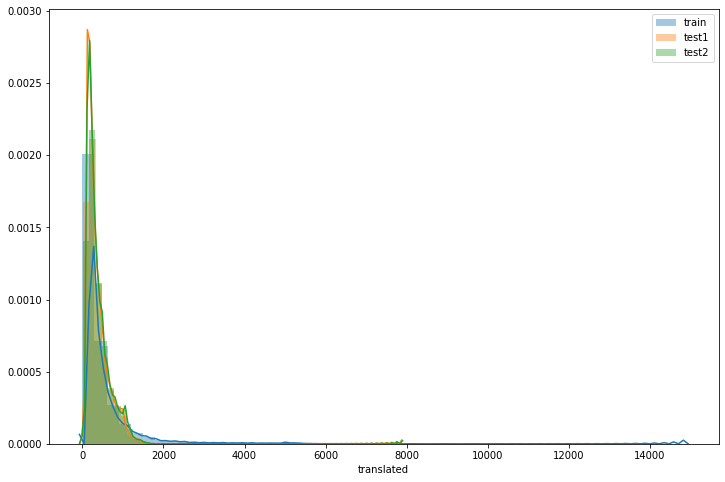

In [ ]:
plt.figure(figsize=(12, 8))

sns.distplot(train1.comment_text.str.len(), label='train')
sns.distplot(test1.content_en.str.len(), label='test1')
sns.distplot(test2.translated.str.len(), label='test2')
plt.legend();

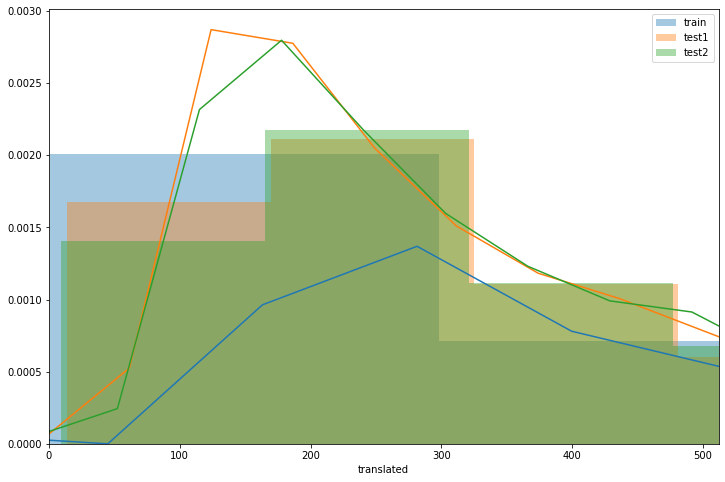

In [ ]:
plt.figure(figsize=(12, 8))

sns.distplot(train1.comment_text.str.len(), label='train')
sns.distplot(test1.content_en.str.len(), label='test1')
sns.distplot(test2.translated.str.len(), label='test2')
plt.xlim([0, 512])
plt.legend();

Lets calculate cosine similarity two translated test datasets.

test_set_similarity = [cosine_sim(t1, t2) for t1, t2 in tqdm(zip(test1.content_en, test2.translated))]

plt.figure(figsize=(12, 8))

sns.distplot(test_set_similarity);

## Fast encode

In [ ]:
x_train = fast_encode(train1.comment_text.astype(str), fast_tokenizer, maxlen=512)
x_valid1 = fast_encode(valid1.comment_text_en.astype(str), fast_tokenizer, maxlen=512)
x_valid2 = fast_encode(valid2.translated.astype(str), fast_tokenizer, maxlen=512)
x_valid = np.concatenate([x_valid1, x_valid2], axis=0)
x_test1 = fast_encode(test1.content_en.astype(str), fast_tokenizer, maxlen=512)
x_test2 = fast_encode(test2.translated.astype(str), fast_tokenizer, maxlen=512)

y_train = train1.toxic.values
y_valid1 = valid1.toxic.values
y_valid2 = valid2.toxic.values
y_valid = np.concatenate([y_valid1, y_valid2], axis=0)

## Build datasets objects

In [ ]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(2048)
    .batch(64)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_valid, y_valid))
    .batch(64)
    .cache()
    .prefetch(AUTO)
)

test_dataset = [(
    tf.data.Dataset
    .from_tensor_slices(x_test1)
    .batch(64)
),
    (
    tf.data.Dataset
    .from_tensor_slices(x_test2)
    .batch(64)
)]

# Focal Loss

In [ ]:
from tensorflow.keras import backend as K

def focal_loss(gamma=2., alpha=.2):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

## Load model into the TPU

In [ ]:
%%time
with strategy.scope():
    transformer_layer = transformers.TFBertModel.from_pretrained('bert-base-cased')
    model = build_model(transformer_layer, loss=focal_loss(gamma=1.5), max_len=512)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 512)]             0         
_________________________________________________________________
tf_bert_model (TFBertModel)  ((None, 512, 768), (None, 108310272 
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 768)]             0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 769       
Total params: 108,311,041
Trainable params: 108,311,041
Non-trainable params: 0
_________________________________________________________________
CPU times: user 22.5 s, sys: 6.54 s, total: 29.1 s
Wall time: 44.4 s


## RocAuc Callback

In [ ]:
from tensorflow.keras.callbacks import Callback 

class RocAucCallback(Callback):
    def __init__(self, test_data, score_thr):
        self.test_data = test_data
        self.score_thr = score_thr
        self.test_pred = []
        
    def on_epoch_end(self, epoch, logs=None):
        if logs['val_auc'] > self.score_thr:
            print('\nRun TTA...')
            for td in self.test_data:
                self.test_pred.append(self.model.predict(td))

# LrScheduler

In [ ]:
def build_lrfn(lr_start=0.000001, lr_max=0.000004, 
               lr_min=0.0000001, lr_rampup_epochs=7, 
               lr_sustain_epochs=0, lr_exp_decay=.87):
    lr_max = lr_max * strategy.num_replicas_in_sync

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_exp_decay**(epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
        return lr
    
    return lrfn

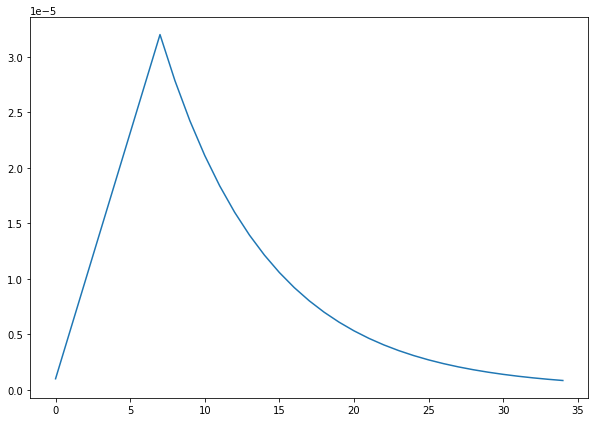

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

_lrfn = build_lrfn()
plt.plot([i for i in range(35)], [_lrfn(i) for i in range(35)]);

## Train Model

### First Stage

In [ ]:
roc_auc = RocAucCallback(test_dataset, 0.935)
lrfn = build_lrfn()
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)

train_history = model.fit(
    train_dataset,
    steps_per_epoch=150,
    validation_data=valid_dataset,
    callbacks=[lr_schedule, roc_auc],
    epochs=35
)

Train for 150 steps, validate for 250 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
Epoch 1/35
150/150 [==============================] - 138s 918ms/step - loss: 0.0625 - auc: 0.4895 - val_loss: 0.0667 - val_auc: 0.5560

Epoch 00002: LearningRateScheduler reducing learning rate to 5.428571428571429e-06.
Epoch 2/35
150/150 [==============================] - 49s 325ms/step - loss: 0.0435 - auc: 0.5449 - val_loss: 0.0564 - val_auc: 0.6199

Epoch 00003: LearningRateScheduler reducing learning rate to 9.857142857142859e-06.
Epoch 3/35
150/150 [==============================] - 49s 327ms/step - loss: 0.0377 - auc: 0.6648 - val_loss: 0.0453 - val_auc: 0.8557

Epoch 00004: LearningRateScheduler reducing learning rate to 1.4285714285714289e-05.
Epoch 4/35
150/150 [==============================] - 49s 327ms/step - loss: 0.0177 - auc: 0.9487 - val_loss: 0.0539 - val_auc: 0.9067

Epoch 00005: LearningRateScheduler reducing learning rate to 1.8714285714285717e-05.
Epoc

# Reference
* [Jigsaw TPU: DistilBERT with Huggingface and Keras](https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras)
* [inference of bert tpu model ml w/ validation](https://www.kaggle.com/abhishek/inference-of-bert-tpu-model-ml-w-validation)
* [Overview of Text Similarity Metrics in Python](https://towardsdatascience.com/overview-of-text-similarity-metrics-3397c4601f50)
* [test-en-df](https://www.kaggle.com/bamps53/test-en-df)
* [val_en_df](https://www.kaggle.com/bamps53/val-en-df)
* [Jigsaw multilingual toxic - test translated](https://www.kaggle.com/kashnitsky/jigsaw-multilingual-toxic-test-translated)